This notebook will explore the Kaggle 2020 Salary Survey Results and attemp to create an ordinal logistic regression model to predict salary. 

Import necessary libraries/packages

In [ ]:
!pip install -U seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

Requirement already up-to-date: seaborn in /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages (0.11.1)


##Load the Dataset with Pandas

In [ ]:


#uncomment these for local directory
kaggle = pd.read_csv('clean_kaggle_data_2020.csv')

#for google drive directory uncomment these
#from google.colab import drive  
#drive.mount('/content/gdrive');
#file_directory = 'gdrive/My Drive/Colab Notebooks/MIE1624/Assignment 2/clean_kaggle_data_2020.csv';
#kaggle = pd.read_csv(file_directory)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,206) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's take a look at the first 5 rows of the DataFrame as well as the shape to understand the number of features and samples we are working with. 

In [ ]:
kaggle.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...",NaN,NaN
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,"10,000-19,999"
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,"125,000-149,9991"
4,762,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,"70,000-79,999"



---



In [ ]:
kaggle.shape

(10730, 357)

##Preliminary Data Cleaning and Encoding

In this section we will do:
- plot heat maps of null values for features (questions) which contain multiple categorical variables and features (questions) which are split into multiple columns for each category
-handle missing values by imputation or other techniques based on the properties of the dataset
-drop unneccesary features such as index
-drop rows (samples) which were completed in less than 3 minutes 
-replace NaN values in multiple part questions with 0 so that we can later easily use one-hot encoding by replacing the categorical variables with 1. 


Let's first plot a heat map to get a sense of the prevalence of null values in the dataset.

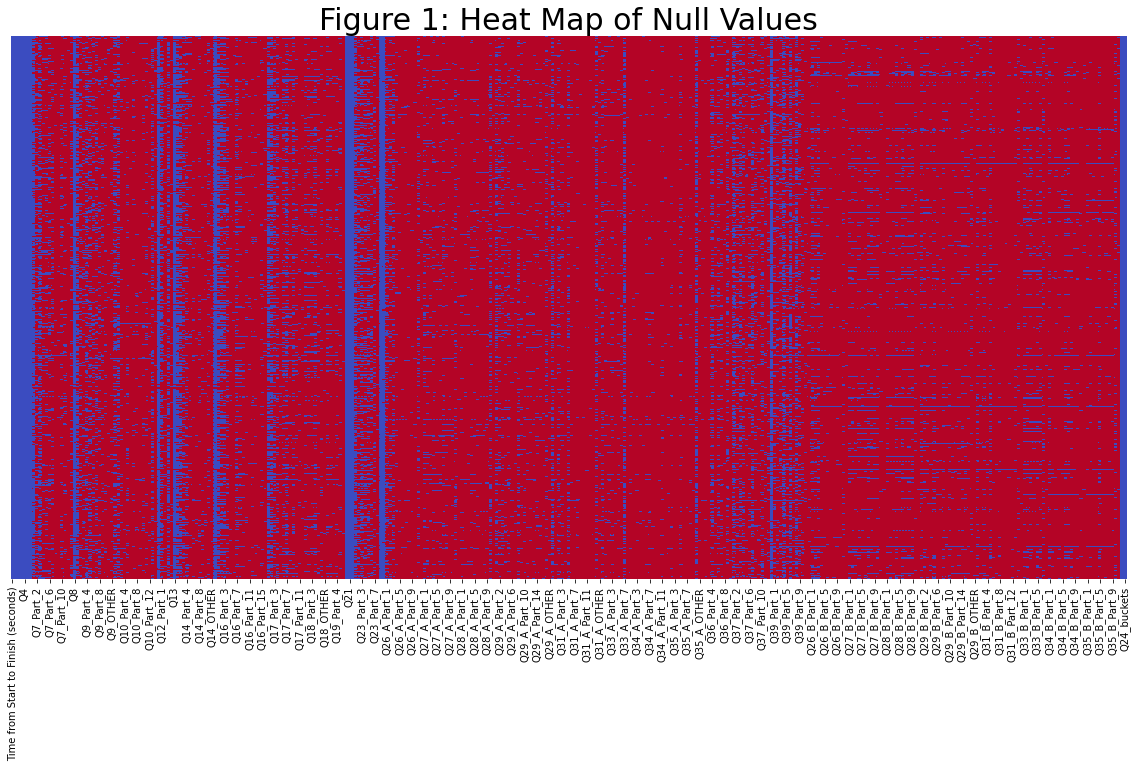

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(kaggle.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
plt.title('Figure 1: Heat Map of Null Values', fontsize = 30);

There are clearly many null values particulary for the MC questions which are split into one column for each option. This is because if an option was not selected then the value would be imported to Pandas as NaN. What this missing value really means is that the survey respondant did choose that option  (i.e. if they don't use R then Q7_Part_2 value would be NaN in our DataFrame). Therefore we can easily replace the NaN values in the multiple choice columns with 0. We need to do this since the logistic regression model can't handle NaN values and needs all numeric values.

We will now consider the NaN values in the non MC questions to see how we can handle them. Let's plot a heat map to see the prevalence of NaN values in the non MC questions. 

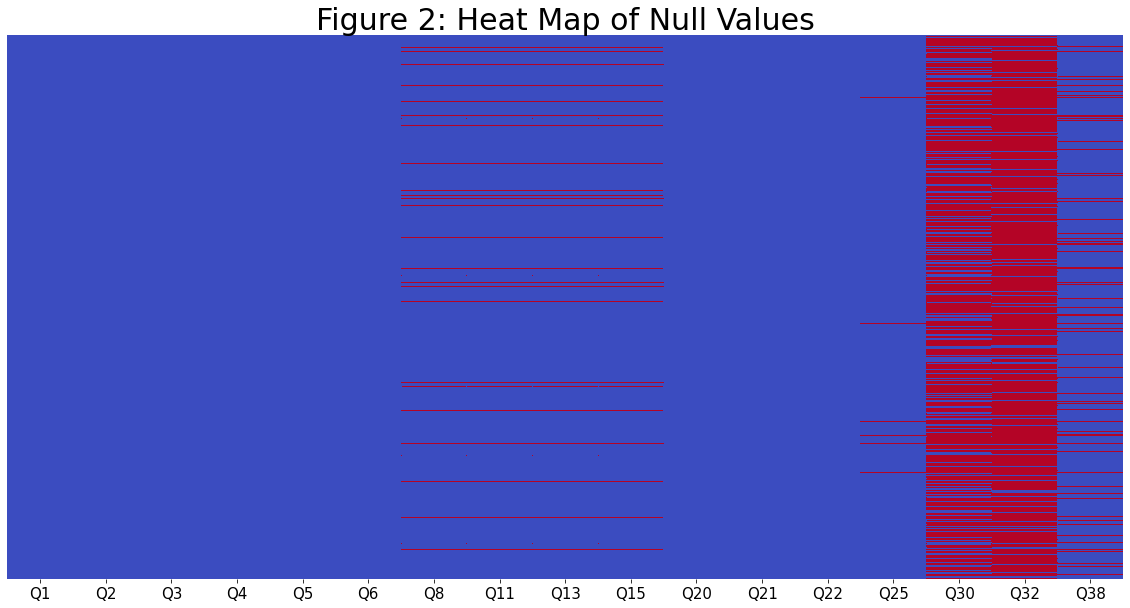

In [ ]:
non_MC = ['Q1','Q2','Q3','Q4','Q5','Q6','Q8','Q11','Q13','Q15','Q20','Q21','Q22','Q25','Q30','Q32', 'Q38']

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(kaggle[non_MC].isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
plt.title('Figure 2: Heat Map of Null Values', fontsize = 30);
plt.xticks(fontsize = 15);

We see there are very few NaN values for most columns except for Q30, Q32. Let's see what these questions are and if they're not important we will drop them. 

In [ ]:
print('Q30:', kaggle['Q30'][0])
print('Q32:', kaggle['Q32'][0])

Q30: Which of the following big data products (relational database, data warehouse, data lake, or similar) do you use most often? - Selected Choice
Q32: Which of the following business intelligence tools do you use most often? - Selected Choice


There are many similar questions to this (asking what software packages used) so we will just drop these features as there aren't enough non-NaN values to accurately impute anything. Of the remaining columns we will impute the mode of each column into the missing data. 

We will also drop the index column as this is not a feature we want to be training on.

In [ ]:
kaggle = kaggle.drop(columns = ['Q30','Q32'])
kaggle.drop(index = 0 , inplace = True)

We will drop any survey respondants which completed the survey in under 180 seconds. This is because they likely didn't spend time thoughtfully choosing answers in this time frame so the data is not useful. 

In [ ]:
row_lessthan3 = kaggle.loc[kaggle['Time from Start to Finish (seconds)'].astype(int) <= 180].index
kaggle = kaggle.drop(row_lessthan3, axis = 0)

Let's impute the missing values for the remaining categorical variables.

In [ ]:
non_MC = ['Q1','Q2','Q3','Q4','Q5','Q6','Q8','Q11','Q13','Q15','Q20','Q21','Q22','Q25', 'Q38']

kaggle.drop(columns = 'Time from Start to Finish (seconds)', inplace = True)
kaggle.reset_index()

for col in non_MC:
    kaggle[col].fillna(kaggle[col].mode()[0], inplace=True)

We have replaced all missing values from the columns in which the categorical data is not seperated into columns. For the remaining columns, the missing or NaN values are in fact just because the option wasn't selected. So we can simply fill the remaining NaNs in the dataset with 0.

In [ ]:
kaggle = kaggle.fillna(0)
kaggle.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
1,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,0,...,0,0,0,0,0,0,0,0,10.0,"100,000-124,999"
2,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,0,0,0,0,...,0,0,0,0,0,0,None,0,1.0,"10,000-19,999"
3,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,0,SQL,0,...,0,0,0,0,0,0,0,0,11.0,"125,000-149,9991"
4,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,0,SQL,0,...,0,0,0,0,0,0,0,0,7.0,"70,000-79,999"
5,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,0,R,0,0,...,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"


Now that we have handled missing data, lets complete the encoding of the dataset. Let's explore through some of the features to see if there is any preliminary data cleaning or adjustment to the features before we do the one-hot encoding.

##Preliminary Feature Exploration
Let's further explore the features of our dataset. In particular we will focus on features that relate to characteristics of the survey respondant. The features we will explore are:

Features we will explore 
- Age (Q1)
- Gender (Q2)
- Country (Q3)
- Education (Q4)
- Current Role (Q5)
- Programming Experience (Q6)
- Programming Language Used (Q7 part 1 - 13)

-We will visualize their relationship with salary which is our target variable. 
-Remove any unnecessary categories or group together when possible or when it is logical to do so.



#### Age



In [ ]:
kaggle['Q1'].value_counts()

25-29    2343
30-34    1974
35-39    1465
22-24    1418
40-44    1040
45-49     771
50-54     536
18-21     497
60-69     309
55-59     299
70+        52
Name: Q1, dtype: int64

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


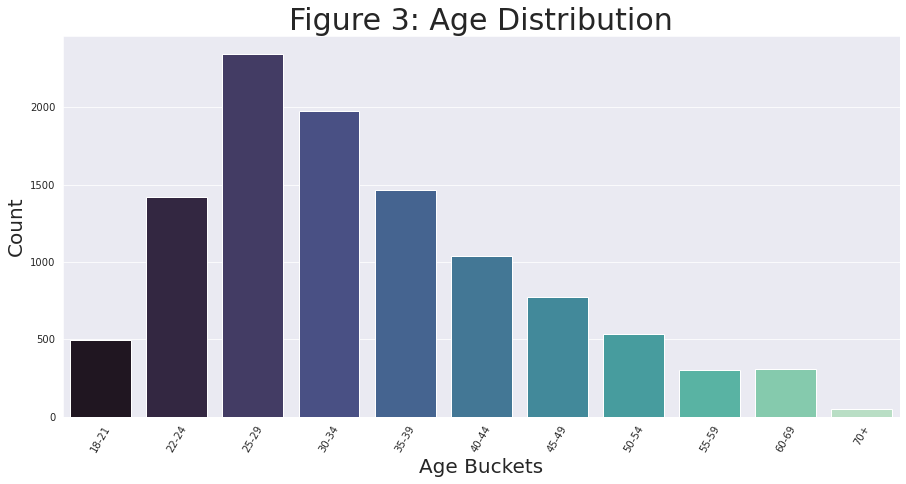

In [ ]:
age_order = ['18-21','22-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-69','70+']
plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
age_count = sns.countplot(kaggle['Q1'], order = age_order, palette='mako')
plt.xticks(rotation = 60)
plt.xlabel('Age Buckets', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Figure 3: Age Distribution', fontsize = 30)
plt.show()


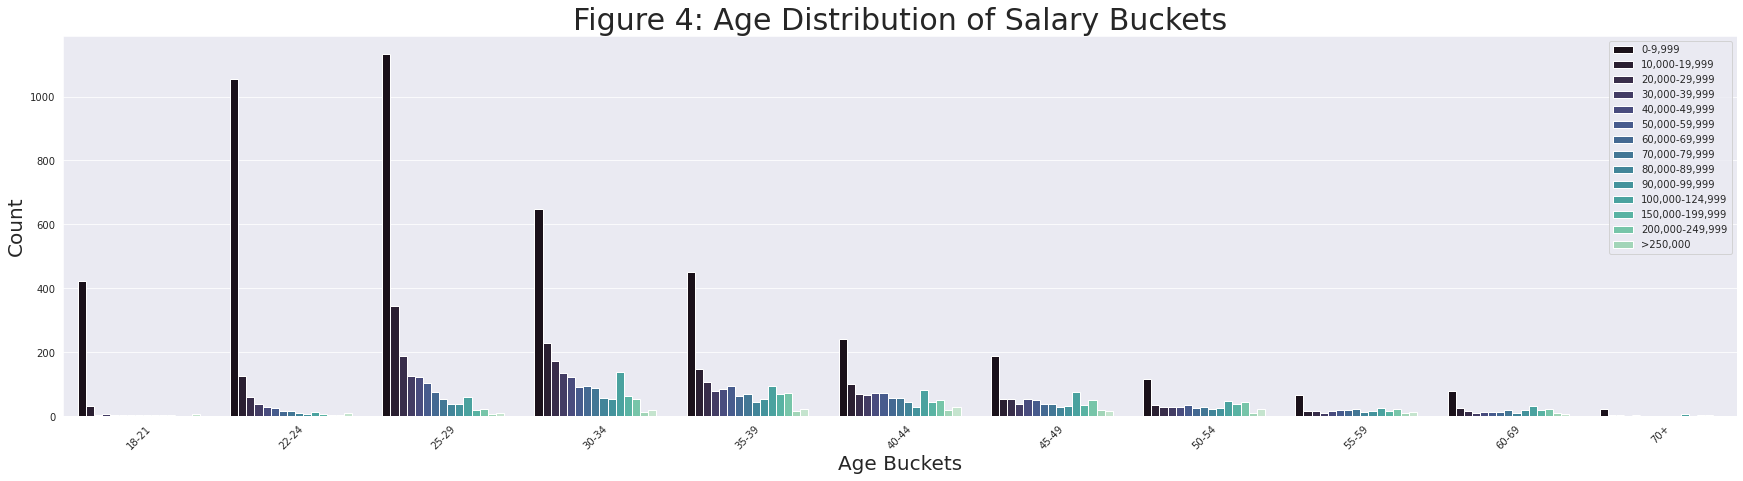

In [ ]:
salary_order = ['0-9,999','10,000-19,999','20,000-29,999','30,000-39,999','40,000-49,999','50,000-59,999','60,000-69,999','70,000-79,999','80,000-89,999','90,000-99,999',
                '100,000-124,999','150,000-199,999','200,000-249,999','>250,000']

plt.figure(figsize=(30,7))
sns.set_style('darkgrid')
age_salary_box = sns.countplot(data = kaggle, hue = 'Q24_Encoded',  x = 'Q1', order = age_order, palette='mako')
plt.xticks(rotation = 45)
plt.xlabel('Age Buckets', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
age_salary_box.set_xticklabels(age_order)
plt.title('Figure 4: Age Distribution of Salary Buckets', fontsize = 30)
plt.legend(loc='upper right', labels = salary_order)
plt.show()


We can see that the younger the age group the more right skewed the distributino is. Only as we get older we see an incrase in frequency of salary earners from higher salary buckets which we expect as they likely have more experience. As the age group increases trhe distribution becomes less and less right skewed and median income increases as well. Therefore age will be a good feature to keep because there appears to be atleast from this visualization, a significance in the data.

####Gender

In [ ]:
kaggle['Q2'].value_counts()

Man                        8851
Woman                      1679
Prefer not to say           131
Prefer to self-describe      23
Nonbinary                    20
Name: Q2, dtype: int64

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


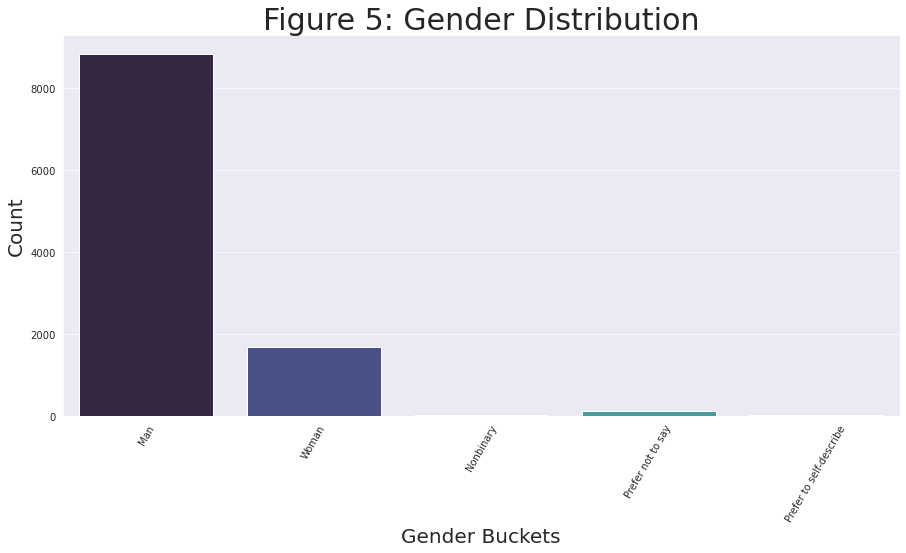

In [ ]:
#age_order = ['18-21','22-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-69','70+']
plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
gender_count = sns.countplot(kaggle['Q2'], palette='mako')
plt.xticks(rotation = 60)
plt.xlabel('Gender Buckets', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Figure 5: Gender Distribution', fontsize = 30)
plt.show()

Most survey respondants are men (8851) with a minority of woman respondants (1679). There are very few respondants who don't identify as either Man or Woman (174). Let's visualize the correlation between gender and salary.

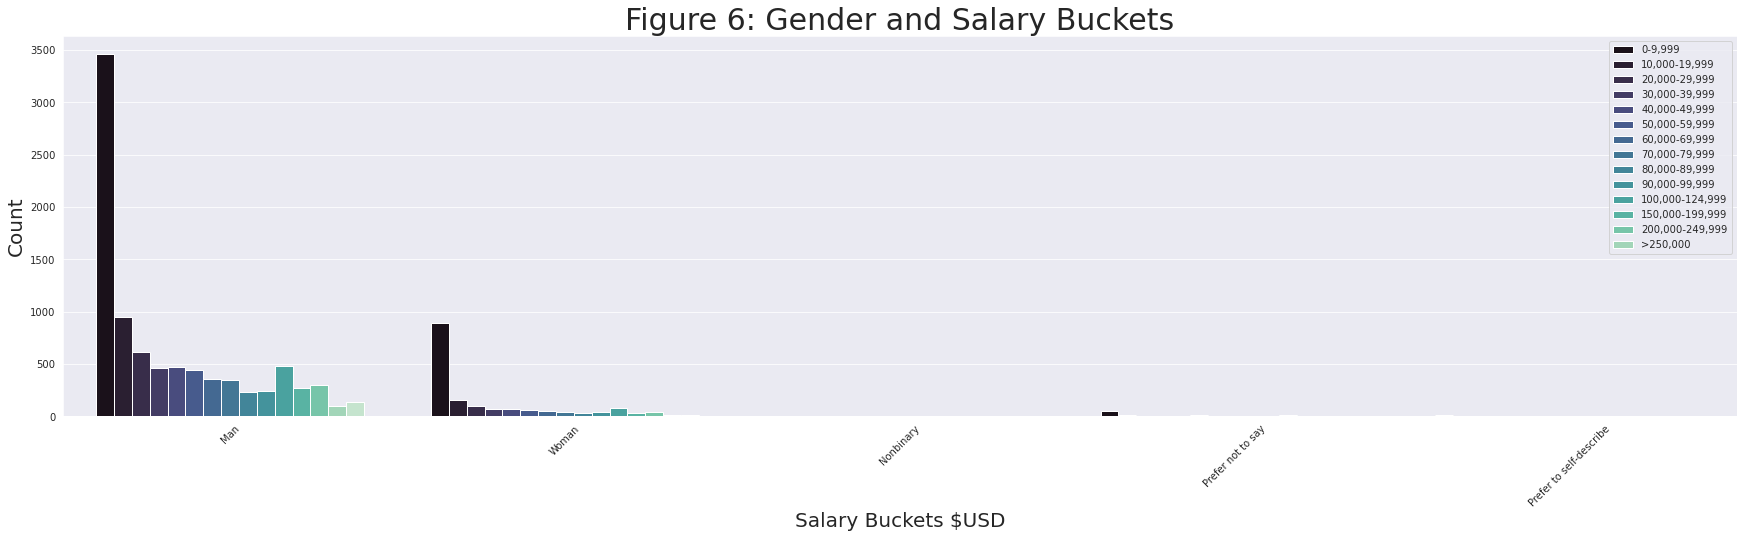

In [ ]:
plt.figure(figsize=(30,7))
sns.set_style('darkgrid')
age_salary_box = sns.countplot(data = kaggle, hue = 'Q24_Encoded',  x = 'Q2', palette='mako')
plt.xticks(rotation = 45)
plt.xlabel('Salary Buckets $USD', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.legend(loc='upper right', labels = salary_order)
plt.title('Figure 6: Gender and Salary Buckets', fontsize = 30)
plt.show()

It is quite clear that median income amongst survey respondants who identified as men is significantly higher than for woman. A larger proportion of woman are in the lowest salary bucket than for men. So we will use gender as a feature as it likely would help predict salary.

We also note that there are very few genders other than Man or Woman so we will remove these.

In [ ]:
kaggle = kaggle[kaggle['Q2'] != 'Nonbinary'][kaggle['Q2'] != 'Prefer not to say'][kaggle['Q2'] != 'Prefer to self-describe'].reset_index()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


####Country

In [ ]:
kaggle['Q3'].value_counts()

India                                                   2318
United States of America                                1436
Other                                                    796
Brazil                                                   443
Japan                                                    381
Russia                                                   346
United Kingdom of Great Britain and Northern Ireland     339
Germany                                                  247
Nigeria                                                  245
Spain                                                    231
Canada                                                   196
France                                                   193
Italy                                                    182
China                                                    162
Turkey                                                   161
Australia                                                137
Mexico                  

Our survey respondants are clearly from a wide plethora of countries. Obviously we know the country one is from can greatly impact salary given the cost of living can be vastly different. We will then create a new feature by organizing specific countries by the median salary bucket they are in. Since we have many countries with less than 100 entries we can group these together into fewer groups which will reduce dimensionality while preserving the relationship between the data. 

In [ ]:
kaggle['Q3'].unique()

country_mapping = {'United States of America': 'North America', 'Argentina':'South America', 'Germany':'Europe', 'Canada':'North America',
       'Switzerland':'Europe', 'India':'India', 'Russia':'Russia', 'South Africa':'Africa', 'Netherlands':'Europe',
       'Pakistan':'Asia', 'Other':'Other', 'Indonesia':'Asia', 'Belarus':'Europe', 'Ukraine':'Europe',
       'Saudi Arabia':'Middle East', 'Taiwan':'Asia', 'China':'Asia', 'Italy':'Europe', 'United Arab Emirates':'Middle East',
       'Colombia':'South America', 'Viet Nam':'Asia',
       'United Kingdom of Great Britain and Northern Ireland':'Europe', 'Egypt':'Africa',
       'Brazil':'South America', 'Mexico':'South America', 'Poland':'Europe', 'Nigeria':'Africa', 'France':'Europe', 'Belgium':'Europe',
       'Turkey':'Asia', 'Spain':'Europe', 'Iran, Islamic Republic of...':'Middle East', 'Japan':'Japan',
       'Tunisia':'Africa', 'Romania':'Europe', 'Republic of Korea':'South Korea', 'Chile':'South America', 'Ireland':'Europe',
       'Sweden':'Europe', 'Greece':'Europe', 'Australia':'Oceania', 'Malaysia':'Asia', 'Philippines':'Asia',
       'Nepal':'Asia', 'Kenya':'Africa', 'South Korea':'South Korea', 'Morocco':'Africa', 'Portugal':'Europe', 'Thailand':'Asia',
       'Peru':'South America', 'Bangladesh':'Asia', 'Israel':'Middle East', 'Sri Lanka':'Asia', 'Singapore':'Asia', 'Ghana':'Africa'}

In [ ]:
median_country = []
for country in kaggle['Q3'].unique():
    median = np.round(kaggle['Q24_Encoded'][kaggle['Q3'] == str(country)].median())
    median_country.append(median)

country_salary_map = {}
for i in range(len(kaggle['Q3'].unique())):
    country_salary_map[str(kaggle['Q3'].unique()[i])] = median_country[i]

country_salary_map
kaggle['Country_Remapped'] = kaggle['Q3'].map(country_salary_map)

Let's now plot the distribution of these grouped countries together by salary level to see if there is anything we can learn from the data.

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


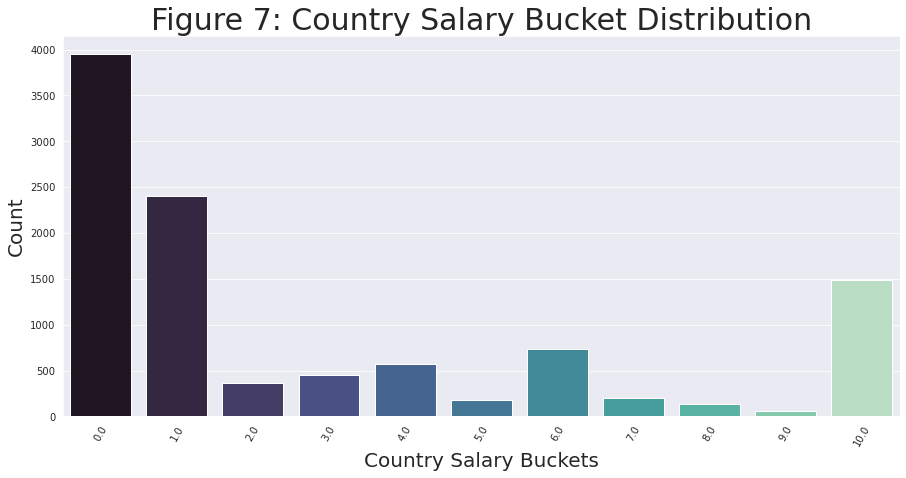

In [ ]:
plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
countr_salary_bins = sns.countplot(kaggle['Country_Remapped'], palette='mako')
plt.xticks(rotation = 60)
plt.xlabel('Country Salary Buckets', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Figure 7: Country Salary Bucket Distribution', fontsize = 30)
plt.show()

We can see that most survey respondants earn from the lowest two salary buckets and the third most common salary bucket is the highest. This will mean there can be significant learning available from what country the person is from so we will use this feature.

####Education

In [ ]:
kaggle['Q4'].value_counts()

Master’s degree                                                      4803
Bachelor’s degree                                                    2963
Doctoral degree                                                      1680
Professional degree                                                   461
Some college/university study without earning a bachelor’s degree     374
I prefer not to answer                                                145
No formal education past high school                                  104
Name: Q4, dtype: int64

Let's visualize the distribution of salary's amongst these education levels.

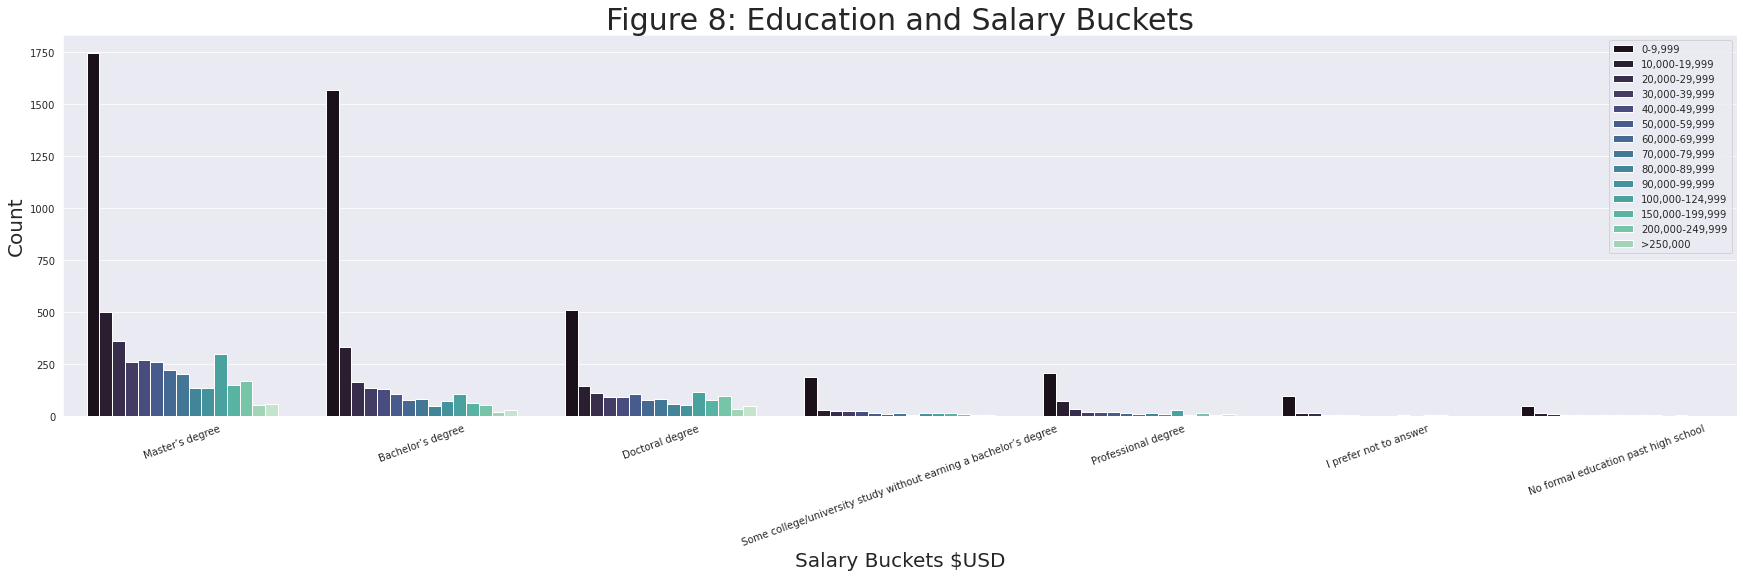

In [ ]:
plt.figure(figsize=(30,7))
sns.set_style('darkgrid')
education_salary = sns.countplot(data = kaggle, hue = 'Q24_Encoded',  x = 'Q4', palette='mako')
plt.xticks(rotation = 20)
plt.xlabel('Salary Buckets $USD', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Figure 8: Education and Salary Buckets', fontsize = 30)
plt.legend(loc='upper right', labels = salary_order)
plt.show()

We see that the distributions are similar amongst education levels with a slight shift towards higher salaries as the education level increases from Bachelor's to Master's to Doctoral. For Doctoral degrees we see a far smaller proportion of earners in the lowest salary bucket relative to salary buckets higher than 9. We also see that amongst the non-university degrees there doesn't appear to be much data and their distributions don't seem significantly different than the overall trend amongst all education levels. We will group together these 4 catgories as either has some formal education or no formal education.

In [ ]:
education_map = {'Master’s degree':'Master’s degree','Bachelor’s degree':'Bachelor’s degree','Doctoral degree':'Doctoral degree',
                 'Some college/university study without earning a bachelor’s degree':'Some Formal Education','Professional degree':'Some Formal Education', 
                 'I prefer not to answer':'No Formal Education','No formal education past high school':'No Formal Education'}

kaggle['Education_Remapped'] = kaggle['Q4'].map(education_map)

####Current Role

In [ ]:
kaggle['Q5'].value_counts()

Data Scientist               2359
Software Engineer            1591
Other                        1483
Data Analyst                 1241
Research Scientist            998
Machine Learning Engineer     902
Business Analyst              663
Product/Project Manager       578
Data Engineer                 364
Statistician                  246
DBA/Database Engineer         105
Name: Q5, dtype: int64

Let's visualize the distribution of salaries amongst these job titles to see if there are any noticeable patterns in the data.

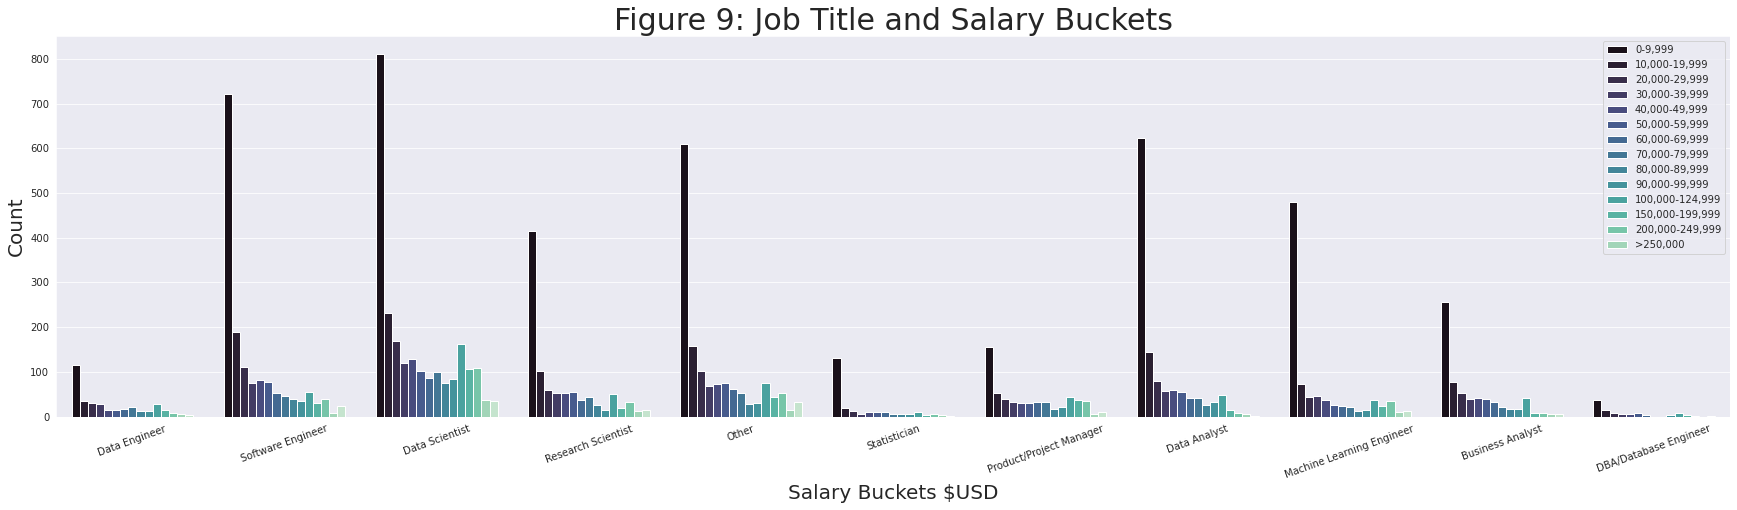

In [ ]:
plt.figure(figsize=(30,7))
sns.set_style('darkgrid')
education_salary = sns.countplot(data = kaggle, hue = 'Q24_Encoded',  x = 'Q5', palette='mako')
plt.xticks(rotation = 20)
plt.xlabel('Salary Buckets $USD', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Figure 9: Job Title and Salary Buckets', fontsize = 30)
plt.legend(loc='upper right')
plt.legend(loc='upper right', labels = salary_order)
plt.show()

We can see the distributions for all job titles are similar. For a few roles we see there is a stronger right skew such as for Statisticians. Data Scientists have the largest number of people in the lowest salary bracket however they also have a significant amount of people in the 10th salary bracket as well which is interesting. 

####Programming Experience

In [ ]:
kaggle['Q6'].value_counts()

3-5 years                    2411
1-2 years                    1878
5-10 years                   1866
10-20 years                  1457
< 1 years                    1267
20+ years                    1122
I have never written code     529
Name: Q6, dtype: int64

Let's visualize the distribution of salaries amongst different levels of programming experience.

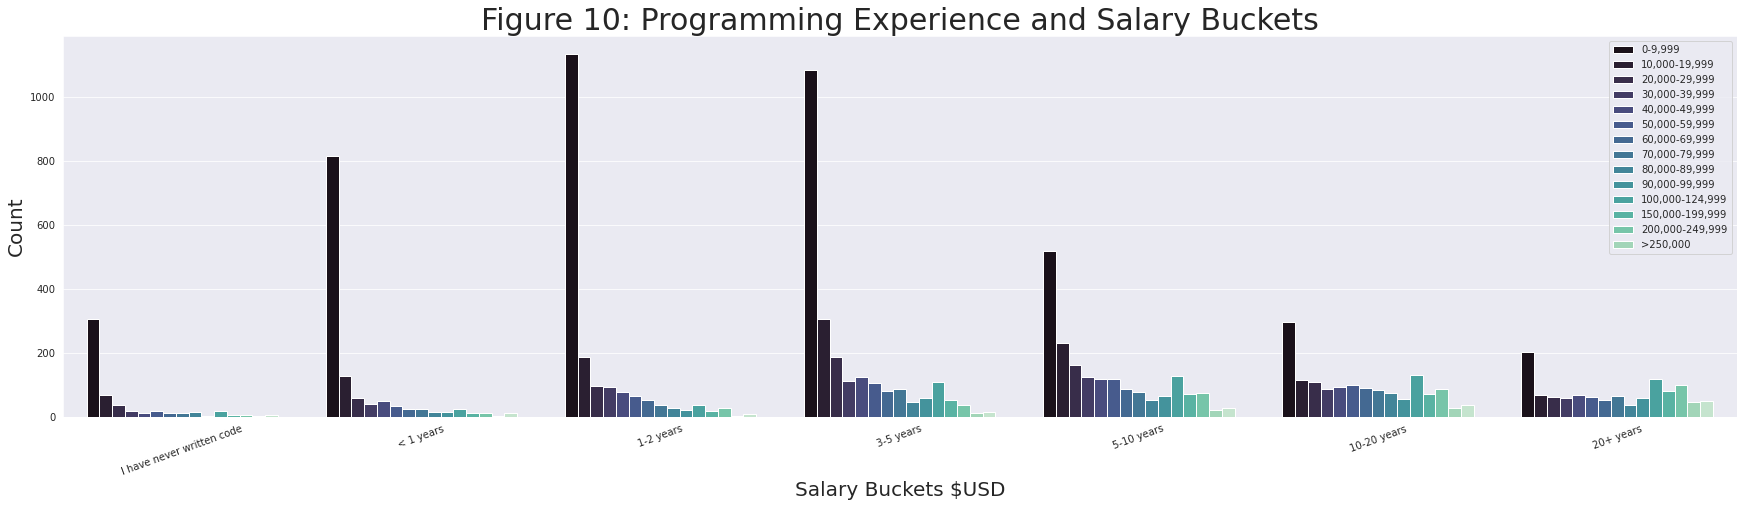

In [ ]:
prog_exp_order = ['I have never written code','< 1 years','1-2 years','3-5 years','5-10 years','10-20 years','20+ years']
plt.figure(figsize=(30,7))
sns.set_style('darkgrid')
education_salary = sns.countplot(data = kaggle, hue = 'Q24_Encoded',  x = 'Q6', palette='mako', order = prog_exp_order)
plt.xticks(rotation = 20)
plt.xlabel('Salary Buckets $USD', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Figure 10: Programming Experience and Salary Buckets', fontsize = 30)
plt.legend(loc='upper right')
plt.legend(loc='upper right', labels = salary_order)
plt.show()

We see that as the amount of programming experience is increased, the distribution is less right skewed and the median salary is higher. This makes sense since usually more experience results in getting a more senior position which has a higher salary. For example, for those who have never written any code there are very few people earning above 40,000 whereas for those with 20+ years experience there is a significant amount. We see that beyond 3-5 years of experience the salarys in the higher end of the salary brackets increase in frequency. This will be a useful feature to keep and use to train our model.

####Programming Language Used

There are 13 parts to Q7 which correspond to 13 different options of programming languages used. Therefore each column is essentially a sub-question asking if a programming language is preferred. For example Q7 part 1 is asking if Python is the preferred language. 

We will plot the distribution of salarys of respondents who use Python and do not.

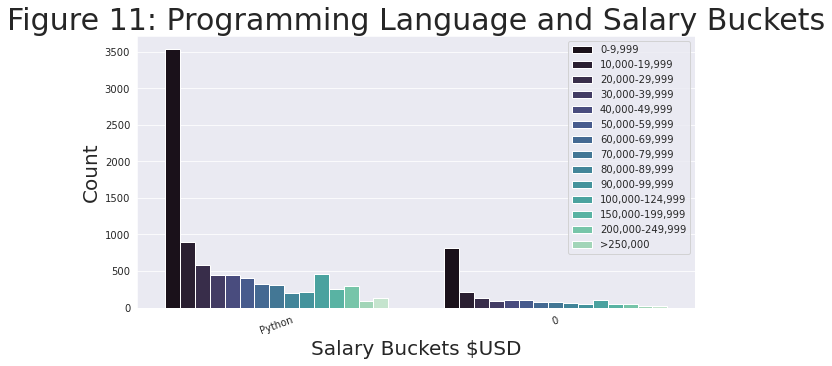

In [ ]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
education_salary = sns.countplot(data = kaggle, hue = 'Q24_Encoded',  x = 'Q7_Part_1', palette='mako')
plt.xticks(rotation = 20)
plt.xlabel('Salary Buckets $USD', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Figure 11: Programming Language and Salary Buckets', fontsize = 30)
plt.legend(loc='upper right')
plt.legend(loc='upper right', labels = salary_order)
plt.show()

On their own it doesn't seem like a particular programming language is correlated with a higher or lower salary however together (if someone knows more than one language) this might increase the salary. We see that the majority of survey respondants use Python than do not.

###Salary (Target Variable)

Let's analyze our Target variable under column 'Q24_buckets' which is based on Q24.

In [ ]:
kaggle['Q24_buckets'].value_counts()

0-9,999             4355
10,000-19,999       1101
20,000-29,999        710
100,000-124,999      561
40,000-49,999        541
30,000-39,999        534
50,000-59,999        501
60,000-69,999        400
70,000-79,999        386
150,000-199,999      339
125,000-149,9991     307
90,000-99,999        275
80,000-89,999        263
>250,000             147
200,000-249,999      110
Name: Q24_buckets, dtype: int64

Let's visualize the distribution of our target variable which is in salary buckets.

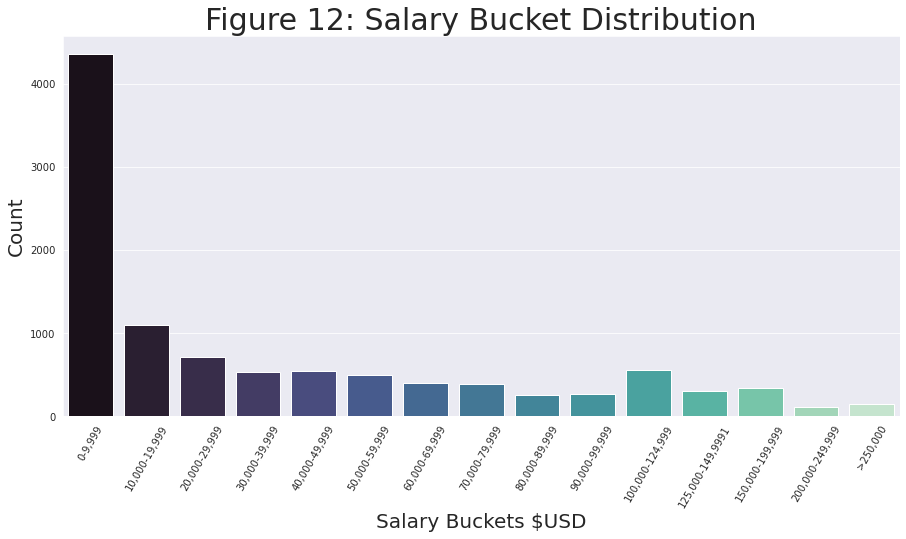

In [ ]:
salary_order = ['0-9,999','10,000-19,999','20,000-29,999','30,000-39,999','40,000-49,999','50,000-59,999','60,000-69,999','70,000-79,999','80,000-89,999','90,000-99,999','100,000-124,999', '125,000-149,9991', '150,000-199,999', '200,000-249,999', '>250,000']
plt.figure(figsize=(15,7))
sns.set_style('darkgrid')
salary_count = sns.countplot(data = kaggle, x = 'Q24_buckets', order = salary_order, palette='mako')
plt.xticks(rotation = 60)
plt.xlabel('Salary Buckets $USD', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Figure 12: Salary Bucket Distribution', fontsize = 30)
plt.show()

The majority of our survey respondents are from the lowest salary bucket ($0-$9,999). This is an important observation as it might affect the performance of our model in predicting respondents who are not in highly populated salary buckets. 

##Further Cleaning and Encoding

- Encode data using One-Hot encoding for data that has no order
- Drop any unneccesary columns or rows


In [ ]:
encoder=OneHotEncoder(sparse=False)

age_arr = pd.DataFrame(encoder.fit_transform(kaggle[['Q1']]))
age_arr.columns = encoder.get_feature_names(['Q1'])

gender_arr = pd.DataFrame(encoder.fit_transform(kaggle[['Q2']]))
gender_arr.columns = encoder.get_feature_names(['Q2'])

role_arr = pd.DataFrame(encoder.fit_transform(kaggle[['Q5']]))
role_arr.columns = encoder.get_feature_names(['Q5'])

exp_arr = pd.DataFrame(encoder.fit_transform(kaggle[['Q6']]))
exp_arr.columns = encoder.get_feature_names(['Q6'])

q8 = pd.DataFrame(encoder.fit_transform(kaggle[['Q8']]))
q8.columns = encoder.get_feature_names(['Q8'])

q11 = pd.DataFrame(encoder.fit_transform(kaggle[['Q11']]))
q11.columns = encoder.get_feature_names(['Q11'])

q13 = pd.DataFrame(encoder.fit_transform(kaggle[['Q13']]))
q13.columns = encoder.get_feature_names(['Q13'])

q15 = pd.DataFrame(encoder.fit_transform(kaggle[['Q15']]))
q15.columns = encoder.get_feature_names(['Q15'])

q20 = pd.DataFrame(encoder.fit_transform(kaggle[['Q20']]))
q20.columns = encoder.get_feature_names(['Q20'])

q21 = pd.DataFrame(encoder.fit_transform(kaggle[['Q21']]))
q21.columns = encoder.get_feature_names(['Q21'])

q22 = pd.DataFrame(encoder.fit_transform(kaggle[['Q22']]))
q22.columns = encoder.get_feature_names(['Q22'])

q25 = pd.DataFrame(encoder.fit_transform(kaggle[['Q25']]))
q25.columns = encoder.get_feature_names(['Q25'])

q38 = pd.DataFrame(encoder.fit_transform(kaggle[['Q38']]))
q38.columns = encoder.get_feature_names(['Q38'])

country_arr = pd.DataFrame(encoder.fit_transform(kaggle[['Country_Remapped']]))
country_arr.columns = encoder.get_feature_names(['Country_Remapped'])

edu_arr = pd.DataFrame(encoder.fit_transform(kaggle[['Education_Remapped']]))
edu_arr.columns = encoder.get_feature_names(['Education_Remapped'])


kaggle = pd.concat([age_arr,gender_arr,country_arr,edu_arr,role_arr,exp_arr,q8,q11,q13,q15,q20,q21,q22,q25,q38,kaggle], axis = 1)
kaggle.drop(columns = ['index','Q1', 'Q2','Q3','Q4', 'Q5', 'Q6','Country_Remapped', 'Education_Remapped', 'Q24', 'Q8','Q11','Q13','Q15','Q20','Q21','Q22','Q25', 'Q38'], inplace=True)


X = kaggle.drop(columns=['Q24_Encoded', 'Q24_buckets'])
y = kaggle['Q24_Encoded']

for i in range(X.shape[1]):
     X.iloc[:,i] = X.iloc[:,i].map(lambda x: 1 if (x!=0) else 0)



In [ ]:
X.head()

,Q1_18-21,Q1_22-24,Q1_25-29,Q1_30-34,Q1_35-39,Q1_40-44,Q1_45-49,Q1_50-54,Q1_55-59,Q1_60-69,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##Feature Selection

- Compute the correlation of each feature.
-Plot the correlations of all features using a heatmap from the Seaborn library
- Choose manually the best features (most highly correlated positively or negatively) to train the model with.

In [ ]:
corr = pd.concat([X,kaggle['Q24_Encoded']], axis = 1).corr()
corr_ascend = np.abs(corr['Q24_Encoded']).sort_values(ascending = False)

We can see the feature which are most correlated with our target variable. Let's do a correlation plot of the top 100 features.

In [ ]:
corr_ascend[0:100]

Q24_Encoded                    1.000000
Country_Remapped_10.0          0.530559
Country_Remapped_0.0           0.432098
Q25_$100,000 or more ($USD)    0.289250
Q6_20+ years                   0.249712
                                 ...   
Q29_A_Part_8                   0.100534
Q29_A_OTHER                    0.100284
Country_Remapped_7.0           0.100073
Q33_A_Part_5                   0.099940
Q5_Data Scientist              0.099317
Name: Q24_Encoded, Length: 100, dtype: float64

There are clearly many features with various levels of correlation. Let's take a closer look at the values.

In [ ]:
np.abs(corr['Q24_Encoded']).sort_values(ascending = False)[0:30]

Q24_Encoded                                                                                   1.000000
Country_Remapped_10.0                                                                         0.530559
Country_Remapped_0.0                                                                          0.432098
Q25_$100,000 or more ($USD)                                                                   0.289250
Q6_20+ years                                                                                  0.249712
Q22_We have well established ML methods (i.e., models in production for more than 2 years)    0.245413
Q23_Part_3                                                                                    0.228829
Q1_22-24                                                                                      0.227265
Q15_5-10 years                                                                                0.222677
Q20_0-49 employees                                                       

In [ ]:
np.abs(corr['Q24_Encoded']).sort_values(ascending = True)[0:30]

Q29_A_Part_7                                                      0.000262
Q16_Part_3                                                        0.000319
Q28_B_OTHER                                                       0.000409
Q33_A_Part_1                                                      0.000961
Q27_B_OTHER                                                       0.001142
Q34_A_Part_8                                                      0.001238
Q38_Local development environments (RStudio, JupyterLab, etc.)    0.001274
Q23_Part_6                                                        0.001335
Q16_Part_14                                                       0.001489
Q29_B_OTHER                                                       0.001609
Q13_6-25 times                                                    0.001685
Q34_A_Part_7                                                      0.001898
Q5_DBA/Database Engineer                                          0.001912
Q27_B_Part_11            

There are no features which are very strongly correlated with the salary (greater than 0.8), however there are few which are particularly high such as the modified country feature we created as well as Q25 which is how much the company spends on ML or Cloud Tools in the past 5 years. Some other features are not correlated at all such as Q29A Part 7 which asks if the respondant uses IBM DB2. This could be simply due to very few respondants select these features in the first place since we have seen these types of questions had many Null Values. Therefore it would make sense for us to drop these features which have very low correlation coefficients because they will likely not improve the accuracy of the model and will speed up computation. We will use the first 20 features with the lowest correlation coefficient of approximately 0.19. 

In [ ]:
features = np.abs(corr['Q24_Encoded']).sort_values(ascending = False)[0:445].index
features_20 = np.abs(corr['Q24_Encoded']).sort_values(ascending = False)[0:21].index

corr_20 = pd.concat([X,kaggle['Q24_Encoded']], axis = 1)[features_20].corr()
corr_20

,Q24_Encoded,Country_Remapped_10.0,Country_Remapped_0.0,"Q25_$100,000 or more ($USD)",Q6_20+ years,"Q22_We have well established ML methods (i.e., models in production for more than 2 years)",Q23_Part_3,Q1_22-24,Q15_5-10 years,Q20_0-49 employees,...,Q15_Under 1 year,"Q25_$10,000-$99,999",Q26_A_Part_1,Q27_A_Part_1,Q25_$0 ($USD),Q21_0,Q6_10-20 years,Country_Remapped_6.0,Q6_1-2 years,Q28_A_Part_10
Q24_Encoded,1.000000,0.530559,-0.432098,0.289250,0.249712,0.245413,0.228829,-0.227265,0.222677,-0.216227,...,-0.214494,0.207583,0.202723,0.198811,-0.194276,-0.193486,0.192342,0.191352,-0.181335,0.177844
Country_Remapped_10.0,0.530559,1.000000,-0.313879,0.146125,0.139654,0.098502,0.087779,-0.097897,0.086958,-0.081156,...,-0.100061,0.056192,0.090792,0.093804,-0.048040,-0.087559,0.051905,-0.111275,-0.082469,0.071252
Country_Remapped_0.0,-0.432098,-0.313879,1.000000,-0.102678,-0.193881,-0.062290,-0.109926,0.235810,-0.107483,0.085935,...,0.143298,-0.104373,-0.021244,-0.036575,0.052576,0.060875,-0.120817,-0.212903,0.125711,-0.097263
"Q25_$100,000 or more ($USD)",0.289250,0.146125,-0.102678,1.000000,0.073536,0.276139,0.131436,-0.040648,0.131614,-0.143569,...,-0.097980,-0.090069,0.158857,0.135043,-0.208044,-0.121578,0.051827,0.073925,-0.056441,0.126776
Q6_20+ years,0.249712,0.139654,-0.193881,0.073536,1.000000,0.050173,0.080894,-0.133137,0.104277,-0.014171,...,-0.132432,0.053512,0.062884,0.060472,-0.070609,-0.017890,-0.138389,0.058145,-0.160893,0.065740
"Q22_We have well established ML methods (i.e., models in production for more than 2 years)",0.245413,0.098502,-0.062290,0.276139,0.050173,1.000000,0.223088,-0.020470,0.201874,-0.171839,...,-0.186000,0.123268,0.162045,0.150140,-0.155413,-0.211693,0.087434,0.062203,-0.077700,0.104498
Q23_Part_3,0.228829,0.087779,-0.109926,0.131436,0.080894,0.223088,1.000000,-0.058017,0.205305,-0.051811,...,-0.270338,0.146273,0.227595,0.214970,-0.219875,-0.244277,0.125485,0.065643,-0.097798,0.140467
Q1_22-24,-0.227265,-0.097897,0.235810,-0.040648,-0.133137,-0.020470,-0.058017,1.000000,-0.102325,0.073088,...,0.084215,-0.039287,-0.031612,-0.038118,0.067812,0.020936,-0.153353,-0.081041,0.142116,-0.061851
Q15_5-10 years,0.222677,0.086958,-0.107483,0.131614,0.104277,0.201874,0.205305,-0.102325,1.000000,-0.070741,...,-0.193503,0.100114,0.099457,0.096481,-0.094981,-0.100083,0.180555,0.069766,-0.124322,0.076026
Q20_0-49 employees,-0.216227,-0.081156,0.085935,-0.143569,-0.014171,-0.171839,-0.051811,0.073088,-0.070741,1.000000,...,0.098258,-0.066429,-0.029992,-0.031406,0.079830,0.231304,-0.072191,-0.033922,0.091898,-0.048621


Text(0.5, 1.0, 'Figure 13: Heat Map of Top 20 Correlated Features')

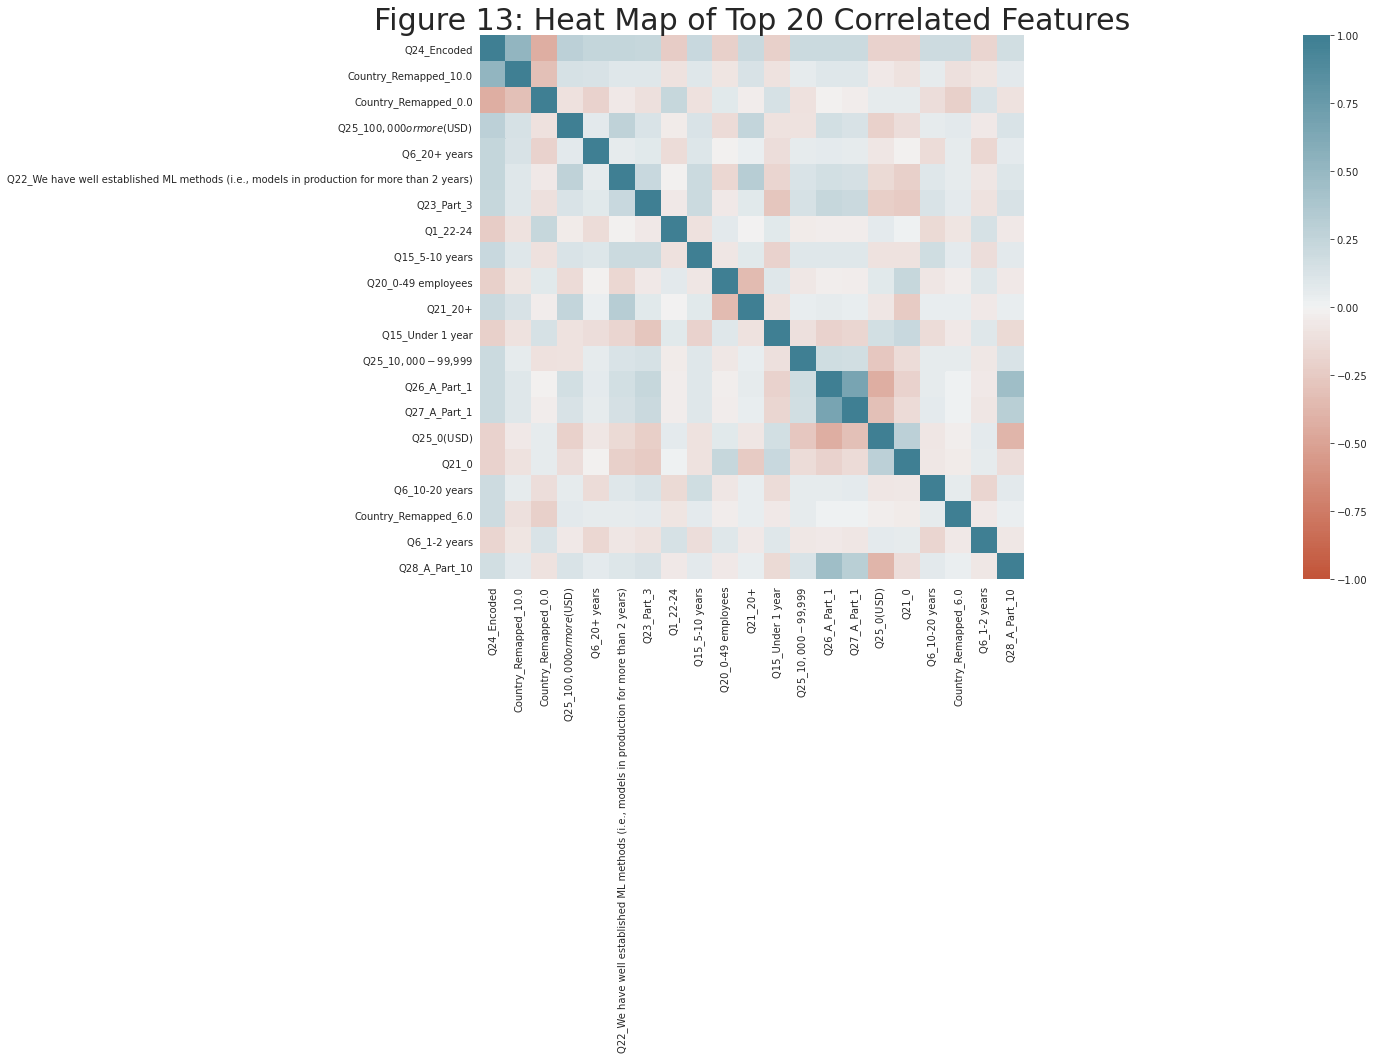

In [ ]:
fig, ax = plt.subplots(figsize=(100,10))
ax = sns.heatmap(corr_20, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
plt.title('Figure 13: Heat Map of Top 20 Correlated Features', fontsize = 30)

We can see from the heatmap above the features with higher correlation by their darker square (blue is positively correlated, red is negatively correlated).

Particularly if we look at the first row we see the correlation compared to the target variable. This is the metric we used to choose our features. By choosing more correlated features we hopefully will allow our model to learn from these relationships in order to better predict the salarys. 

In [ ]:
X

,Q1_18-21,Q1_22-24,Q1_25-29,Q1_30-34,Q1_35-39,Q1_40-44,Q1_45-49,Q1_50-54,Q1_55-59,Q1_60-69,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10525,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
10526,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10527,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10528,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [ ]:
X = pd.concat([X,kaggle['Q24_Encoded']], axis = 1)[features].drop(columns = 'Q24_Encoded')


In [ ]:
pca = PCA(n_components=300)
pca.fit(X)
expl_90 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.90 )[0][0]+1
print('The number of components required to explain 90% of the variance is:', expl_90)

The number of components required to explain 90% of the variance is: 220


There are currently 455 features in our dataset. We will use PCA to select those features which explain 90% of the variance of the data.

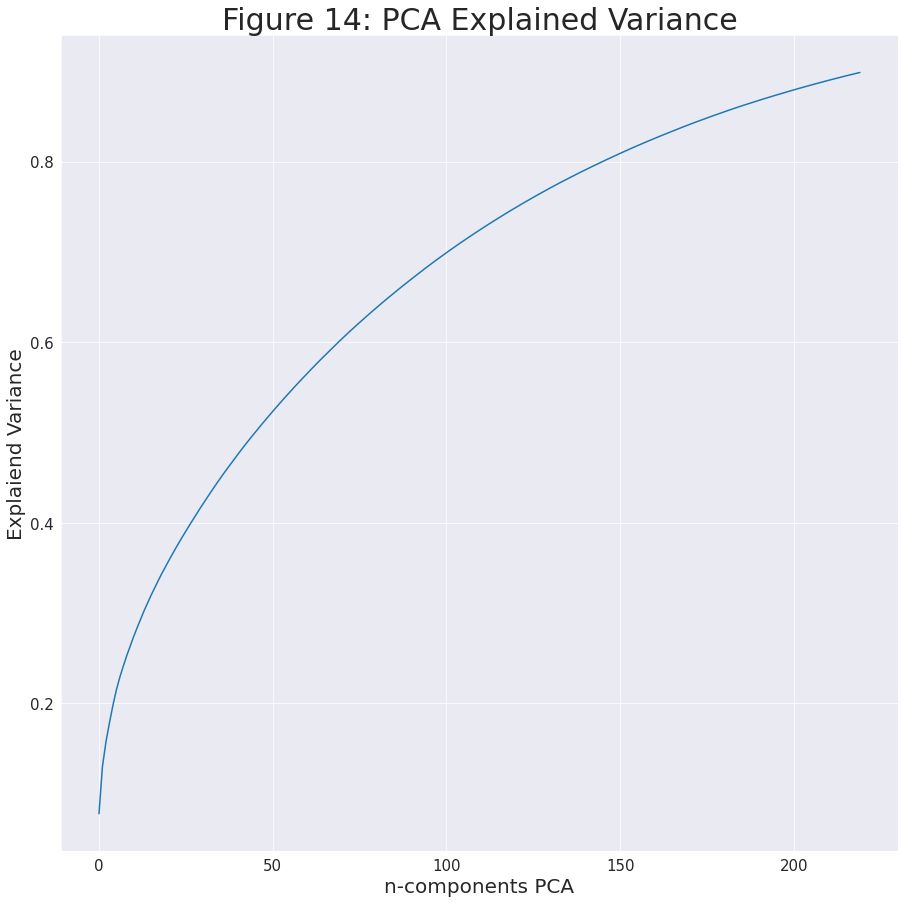

In [ ]:
#use PCA
pca = PCA(n_components=expl_90)
X = pca.fit_transform(X)
plt.figure(figsize=(15,15))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Figure 14: PCA Explained Variance', fontsize = 30)
plt.xlabel('n-components PCA', fontsize =20)
plt.ylabel('Explaiend Variance', fontsize = 20);
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

## Model Implementation

- Implement ordinal logistic regression by performing binary logistic regression n-1 times where n is the number of salary classes. (n=15)

- Compute the accuracy when training on 80% of the data and testing on 20%. 

- Train the model again but use 10 fold cross validation and compare the accuracy and F1 score across folds.

- Discuss average accuracy and variance of accuracy and how it relates to model performance (underfitting, overfitting). 

- F1 metric used because dataset is skewed and it provides a more accurate representation of our model performance.





Create a function which will compute the probability distribution of each sample belonging to each salary bucket using the results of the binary logistic regression being done n-1 times. 

In [ ]:
def compute_distribution(p):
    p[1] = p[1]-p[0] # class 2
    p[2] = p[2]- (p[1] + p[0]) #class 3
    p[3] = p[3]- (p[2] + p[1] + p[0]) #class 4
    p[4] = p[4]- (p[3] + p[2] + p[1] + p[0]) #class 5
    p[5] = p[5]- (p[4]+p[3] + p[2] + p[1] + p[0]) #class 6
    p[6] = p[6]- (p[5]+ p[4] + p[3] + p[2] + p[1] + p[0]) #class 7
    p[7] = p[7]- (p[6] + p[5] + p[4] + p[3] + p[2] + p[1] + p[0]) #class 8
    p[8] = p[8]- (p[7] + p[6] + p[5] + p[4] + p[3] + p[2] + p[1] + p[0]) #class 9
    p[9] = p[9]- (p[8] + p[7] + p[6] + p[5] + p[4] + p[3] + p[2] + p[1] + p[0]) #class 10
    p[10] = p[10]- (p[9] + p[8] + p[7] + p[6] + p[5] + p[4] + p[3] + p[2] + p[1] + p[0]) #class 11
    p[11] = p[11]- (p[10] + p[9] + p[8] + p[7] + p[6] + p[5] + p[4] + p[3] + p[2] + p[1] + p[0]) #class 12
    p[12] = p[12]- (p[11] + p[10] + p[9] + p[8] + p[7] + p[6] + p[5] + p[4] + p[3] + p[2] + p[1] + p[0]) #class 13
    p[13] = p[13]- (p[12] + p[11] + p[10] + p[9] + p[8] + p[7] + p[6] + p[5] + p[4] + p[3] + p[2] + p[1] + p[0]) #class 14
    p.append(1- (p[13] + p[12] + p[11] + p[10] + p[9] + p[8] + p[7] + p[6] + p[5] + p[4] + p[3] + p[2] + p[1] + p[0]))

    return p



Implement the code to complete the the ordinal logistic regression without k-fold cross validation and display the results. 

In [ ]:
p = []
p_test = []
train_score = []
test_score = []
for j in range(14):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15, test_size=0.2)
    y_binary_train = y_train.map(lambda x: 0 if x <= j else 1)
    model = LogisticRegression(random_state=0, solver = 'lbfgs').fit(X_train, y_binary_train)
    p.append(model.predict_proba(X_train)[:,0])
    p_test.append(model.predict_proba(X_test)[:,0])

p = compute_distribution(p)
p_test = compute_distribution(p_test)

p_distribution = np.zeros(shape = (len(X_train),15))
p_distribution_test = np.zeros(shape = (len(X_test),15))

for sample in range(len(X_train)):
    p_distribution[sample] = [p[0][sample],p[1][sample],p[2][sample],p[3][sample],p[4][sample],p[5][sample],p[6][sample],p[7][sample],p[8][sample],p[9][sample],p[10][sample],p[11][sample],p[12][sample],p[13][sample],p[14][sample]]
    
for sample in range(len(X_test)):
    p_distribution_test[sample] = [p_test[0][sample],p_test[1][sample],p_test[2][sample],p_test[3][sample],p_test[4][sample],p_test[5][sample],p_test[6][sample],p_test[7][sample],p_test[8][sample],p_test[9][sample],p_test[10][sample],p_test[11][sample],p_test[12][sample],p_test[13][sample],p_test[14][sample]]

y_pred_train = np.argmax(p_distribution, axis = 1)
y_pred_test = np.argmax(p_distribution_test, axis = 1)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

train_acc, test_acc

(0.5070037986704653, 0.4154795821462488)

The results of our model show an accuracy of 50.6% on the training data and 42.1% on the test set. As expected the test accuracy is slighly worse given the model has never seen the data before. Overall the accuracy is quite low so the model did not learn from the data well.

We will now conduct 10-fold cross-validation to see if our accuracy will change. 

In [ ]:
def logRegression(X, y):
    kf = KFold(n_splits=10)
    
    test_accuracy = []
    f1 = []
    #training_accuracy = []
    distributions_train = []
    distributions_test = []
    fold = 0
    for train_index, test_index in kf.split(X):
        fold+=1
        X_train, X_test = X[train_index], X[test_index]

        p = []
        p_test = []
        for j in range(14):
            y_train_binary = y.map(lambda x: 0 if x <= j else 1)
            y_train, y_test = y_train_binary[train_index], y_train_binary[test_index]
            model = LogisticRegression(random_state=0, solver = 'lbfgs').fit(X_train, y_train)
            p.append(model.predict_proba(X_train)[:,0])
            p_test.append(model.predict_proba(X_test)[:,0])

        p = compute_distribution(p)
        p_test = compute_distribution(p_test)

        p_distribution = np.zeros(shape = (len(X_train),15))
        p_distribution_test = np.zeros(shape = (len(X_test),15))
        for sample in range(len(X_train)):
            p_distribution[sample] = [p[0][sample],p[1][sample],p[2][sample],p[3][sample],p[4][sample],p[5][sample],p[6][sample],p[7][sample],p[8][sample],p[9][sample],p[10][sample],p[11][sample],p[12][sample],p[13][sample],p[14][sample]]
            
        for sample in range(len(X_test)):
            p_distribution_test[sample] = [p_test[0][sample],p_test[1][sample],p_test[2][sample],p_test[3][sample],p_test[4][sample],p_test[5][sample],p_test[6][sample],p_test[7][sample],p_test[8][sample],p_test[9][sample],p_test[10][sample],p_test[11][sample],p_test[12][sample],p_test[13][sample],p_test[14][sample]]

        y_pred_train = np.argmax(p_distribution, axis = 1)
        y_pred_test = np.argmax(p_distribution_test, axis = 1)

        train_acc = accuracy_score(y.iloc[train_index], y_pred_train)
        test_acc = accuracy_score(y.iloc[test_index], y_pred_test)
        f1_local = f1_score(y.iloc[test_index], y_pred_test, average = 'weighted')

        #training_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        f1.append(f1_local)
        print("Fold {0} accuracy: {1}".format(fold, np.round(test_acc,2)))
        print("Fold {0} F1 Score: {1}".format(fold, np.round(f1_local,2)))

        distributions_train.append(p_distribution)
        distributions_test.append(p_distribution_test)
       

    return distributions_train, distributions_test, test_accuracy, f1

Let's run the model and display the accuracy and f1 score across the folds.

In [ ]:
train_distributions,test_distributions,test_accuracy, f1 = logRegression(X,y)

Fold 1 accuracy: 0.46
Fold 1 F1 Score: 0.4
Fold 2 accuracy: 0.45
Fold 2 F1 Score: 0.4
Fold 3 accuracy: 0.42
Fold 3 F1 Score: 0.35
Fold 4 accuracy: 0.43
Fold 4 F1 Score: 0.38
Fold 5 accuracy: 0.43
Fold 5 F1 Score: 0.37
Fold 6 accuracy: 0.43
Fold 6 F1 Score: 0.37
Fold 7 accuracy: 0.44
Fold 7 F1 Score: 0.37
Fold 8 accuracy: 0.42
Fold 8 F1 Score: 0.35
Fold 9 accuracy: 0.42
Fold 9 F1 Score: 0.36
Fold 10 accuracy: 0.43
Fold 10 F1 Score: 0.38


In [ ]:
print('The average accuracy across the folds is:', np.round(np.mean(test_accuracy),2))
print('The variance of the accuracy across the folds is:', np.round(np.var(test_accuracy),2))

print('The average f1 score across the folds is:', np.round(np.mean(f1),2))
print('The variance of the f1 score across the folds is:', np.round(np.var(f1),2))


The average accuracy across the folds is: 0.43
The variance of the accuracy across the folds is: 0.0
The average f1 score across the folds is: 0.37
The variance of the f1 score across the folds is: 0.0


The average accuracy from cross-validatoin are nearly equivalent to the accuracy we obtained without cross-validation. This is not suprising as we also see the variance of the accuracy across the folds is 0.  

As we discussed previously the target data is highly skewed (mostly all belong to the lowest salary bucket). Hence F1 score could be a useful metric for skewed datasets to give a better explanation of model performance. The F1 score is also quite low with an average value of 0.32 from cross-validation. This further confirms our model does not perform well and did not learn well from the dataset. 


##Model Tuning

- Modified existing logistic regression algorithm to include for gridsearch of hyperparameters. Algorithm made to output distributions, training and test accuracy and f1 score

- Chose to tune penalty and inverse regularization hyperparameters. Found the optimal hyperparameters which maximize our performance metrics to be penalty = 'L1' and C = 1

In our logistic regression there are several hyperparameters. Many of which we leave as default given they are related to the solver method, convergence criterion, computation heuristics like warm-start, if it is multi-class logisitc regression, etc. I will choose to tune the regularization penalty hyperparameter and the Inverse Regularization Parameter which affects the strength of regularization.  

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def logRegression_Grid(X, y, regularization_parameters, C):
    average_accuracy = []
    average_train_accuracy = []
    average_f1 = []
    average_f1_train = []
    for parameter in regularization_parameters:
        for c in C:

            kf = KFold(n_splits=10)
            
            test_accuracy = []
            train_accuracy = []
            f1 = []
            f1_train = []
            distributions_train = []
            distributions_test = []
            fold = 0
            for train_index, test_index in kf.split(X):
                fold+=1
                X_train, X_test = X[train_index], X[test_index]

                p = []
                p_test = []
                for j in range(14):
                    y_train_binary = y.map(lambda x: 0 if x <= j else 1)
                    y_train, y_test = y_train_binary[train_index], y_train_binary[test_index]
                    ignore_warnings(category=ConvergenceWarning)
                    model = LogisticRegression(random_state=0, penalty= parameter, C = c, solver = 'saga', max_iter = 100).fit(X_train, y_train)
                    p.append(model.predict_proba(X_train)[:,0])
                    p_test.append(model.predict_proba(X_test)[:,0])

                p = compute_distribution(p)
                p_test = compute_distribution(p_test)

                p_distribution = np.zeros(shape = (len(X_train),15))
                p_distribution_test = np.zeros(shape = (len(X_test),15))
                for sample in range(len(X_train)):
                    p_distribution[sample] = [p[0][sample],p[1][sample],p[2][sample],p[3][sample],p[4][sample],p[5][sample],p[6][sample],p[7][sample],p[8][sample],p[9][sample],p[10][sample],p[11][sample],p[12][sample],p[13][sample],p[14][sample]]
                    
                for sample in range(len(X_test)):
                    p_distribution_test[sample] = [p_test[0][sample],p_test[1][sample],p_test[2][sample],p_test[3][sample],p_test[4][sample],p_test[5][sample],p_test[6][sample],p_test[7][sample],p_test[8][sample],p_test[9][sample],p_test[10][sample],p_test[11][sample],p_test[12][sample],p_test[13][sample],p_test[14][sample]]

                y_pred_train = np.argmax(p_distribution, axis = 1)
                y_pred_test = np.argmax(p_distribution_test, axis = 1)

                train_acc = accuracy_score(y.iloc[train_index], y_pred_train)
                test_acc = accuracy_score(y.iloc[test_index], y_pred_test)
                f1_local = f1_score(y.iloc[test_index], y_pred_test, average = 'weighted')
                f1_local_train = f1_score(y.iloc[train_index], y_pred_train, average = 'weighted')
                test_accuracy.append(test_acc)
                train_accuracy.append(train_acc)
                f1.append(f1_local)
                f1_train.append(f1_local_train)
                #print("Fold {0} accuracy: {1}".format(fold, np.round(test_acc,2)))
                #print("Fold {0} F1 Score: {1}".format(fold, np.round(f1_local,2)))

                distributions_train.append(p_distribution)
                distributions_test.append(p_distribution_test)

            #average the accuracy and f1 for the 10 folds
            average_accuracy.append(np.mean(test_accuracy))
            average_train_accuracy.append(np.mean(train_accuracy))
            average_f1.append(np.mean(f1))
            average_f1_train.append(np.mean(f1_train))
            print("Penalty:", parameter, 'C =', c, 'Average Test Accuracy:', np.mean(test_accuracy))
            print("Penalty:", parameter, 'C =', c, 'Average Test F1 Score:', np.mean(f1))
            



    return distributions_train, distributions_test, average_accuracy, average_f1, average_train_accuracy, average_f1_train


Run and display grid search algorithm results

In [ ]:
penalty = ['l1', 'l2']
C = [0.01, 1, 10, 100]

#comment out Cross-validation gridsearch for submission
#training_distributions, test_distributions, average_accuracy, average_f1, average_accuracy_train, average_f1_train = logRegression_Grid(X,y, penalty, C)

We can see from the grid search we did using cross-validation the average accuracy and f1 scores. 

Penalty: l1 C = 0.01 Average Test Accuracy: 0.4234567901234568

Penalty: l1 C = 0.01 Average Test F1 Score: 0.27898533477626175

Penalty: l1 C = 1 Average Test Accuracy: 0.433048433048433

Penalty: l1 C = 1 Average Test F1 Score: 0.370031059603021

Penalty: l1 C = 10 Average Test Accuracy: 0.431718898385565

Penalty: l1 C = 10 Average Test F1 Score: 0.37067584663072395

Penalty: l1 C = 100 Average Test Accuracy: 0.4314339981006648

Penalty: l1 C = 100 Average Test F1 Score: 0.3708134926614638

Penalty: l2 C = 0.01 Average Test Accuracy: 0.4417853751187085

Penalty: l2 C = 0.01 Average Test F1 Score: 0.3314610491375844

Penalty: l2 C = 1 Average Test Accuracy: 0.431718898385565

Penalty: l2 C = 1 Average Test F1 Score: 0.3698801957762793

Penalty: l2 C = 10 Average Test Accuracy: 0.4315289648622982

Penalty: l2 C = 10 Average Test F1 Score: 0.37082365047782495

Penalty: l2 C = 100 Average Test Accuracy: 0.4315289648622982

Penalty: l2 C = 100 Average Test F1 Score: 0.37096583545298306


Based on these results we can choose the model hyperparameters that have the best accuracy of 0.4417853 is L2, C = 0.01 and the best f1 score of 0.3709658 is L2, C = 100.





The best model hyperparameters for accuracy are L2, C=0.1. For F1 score it is L2, C= 100.  We will use the model that has hte best F1 score as it is a more suitable metric for displaying model performance. 

##Model Testing and Discussion 

- Trained a model using optimal hyperparameters

- Computed the probability distributions of each training and test point belonging to each salary bucket. 

- Visualized distributions of the probability of belonging to salary classes for each sample for the training and the test data.

- Observed that there is no siginificant difference in distributions for training and test data. 

- Computed the accuracy of the model predicting each class and plotted the results. Class 0-9,999 has the highest accuracy of approximately 75%. It is likely because of it is the largest proportion of the data so the model has more points to train from. Additionally it is more likely to guess correctly just based on a higher frequency of this salary bucket in the dataset. 

In [ ]:
training_dists, test_dists, avg_acc_test, avg_f1_test, avg_acc_train,avg_acc_f1= logRegression_Grid(X,y, ['l2'], [100])

Penalty: l2 C = 100 Average Test Accuracy: 0.4320037986704654
Penalty: l2 C = 100 Average Test F1 Score: 0.3724462999630766


Actual true salary bucket is:, 20,000-29,999


Text(0, 0.5, 'Freq.')

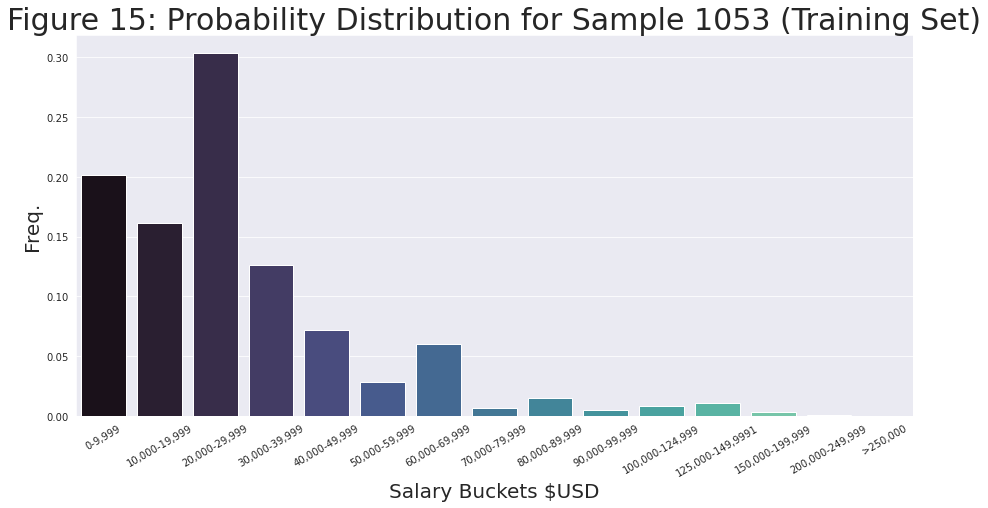

In [ ]:
plt.figure(figsize=(15,7))
fig = sns.barplot(y= training_dists[0][1053], x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], palette='mako') #distribution of sample point 1053
plt.title('Figure 15: Probability Distribution for Sample 1053 (Training Set)', fontsize = 30)
fig.set_xticklabels(salary_order, rotation = 30)
print('Actual true salary bucket is:,', kaggle.loc[1053,:][-1])
fig.set_xlabel('Salary Buckets $USD', fontsize = 20)
fig.set_ylabel('Freq.', fontsize = 20)

Actual true salary bucket is:, 0-9,999


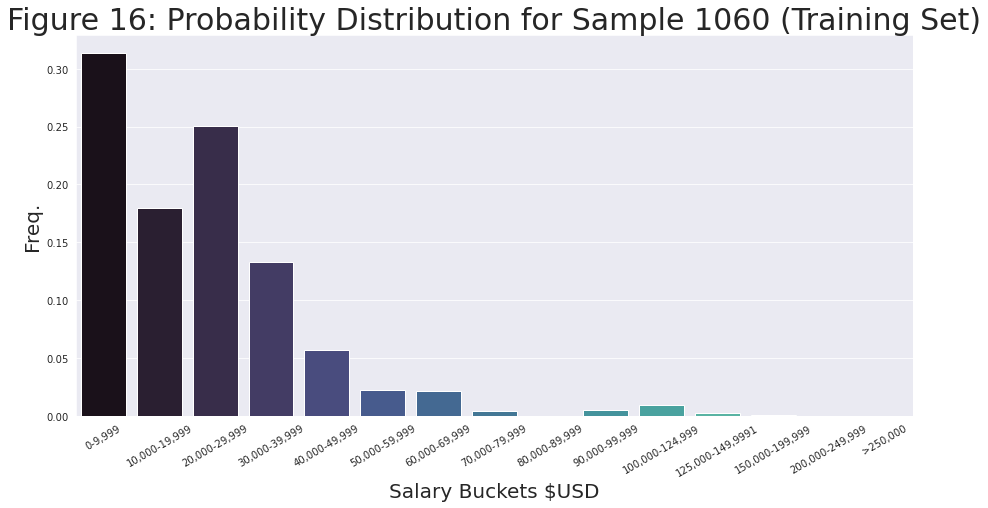

In [ ]:
plt.figure(figsize=(15,7))
fig = sns.barplot(y= training_dists[0][1060], x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], palette='mako') #distribution of sample point 1060
plt.title('Figure 16: Probability Distribution for Sample 1060 (Training Set)', fontsize = 30)
fig.set_xticklabels(salary_order, rotation = 30)
print('Actual true salary bucket is:,', kaggle.loc[1060,:][-1])
fig.set_xlabel('Salary Buckets $USD', fontsize = 20)
fig.set_ylabel('Freq.',fontsize = 20);

Actual true salary bucket is:, 200,000-249,999


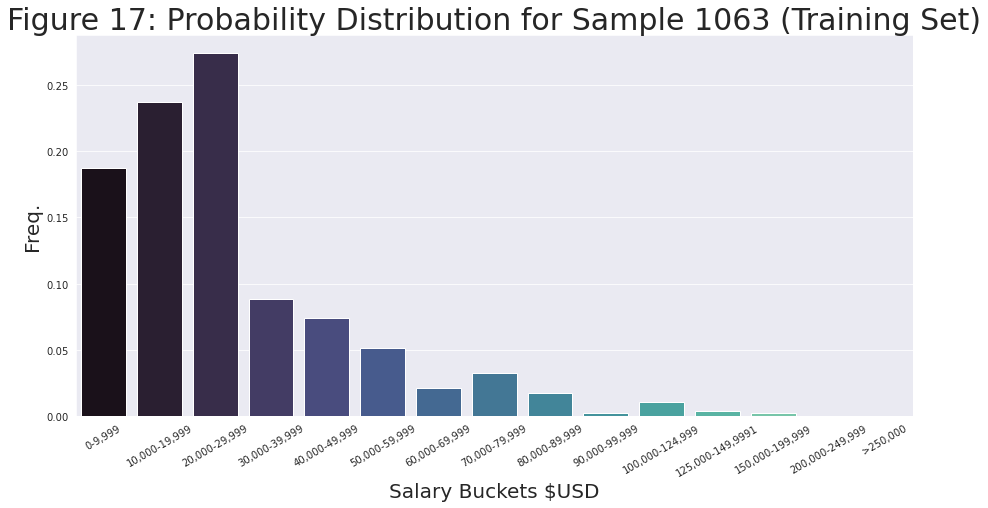

In [ ]:
plt.figure(figsize=(15,7))
fig = sns.barplot(y= training_dists[0][1063], x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], palette='mako') #distribution of sample point 1053
plt.title('Figure 17: Probability Distribution for Sample 1063 (Training Set)', fontsize = 30)
fig.set_xticklabels(salary_order, rotation = 30)
print('Actual true salary bucket is:,', kaggle.loc[1063,:][-1])
fig.set_xlabel('Salary Buckets $USD', fontsize = 20)
fig.set_ylabel('Freq.', fontsize = 20);

Actual true salary bucket is:, 100,000-124,999


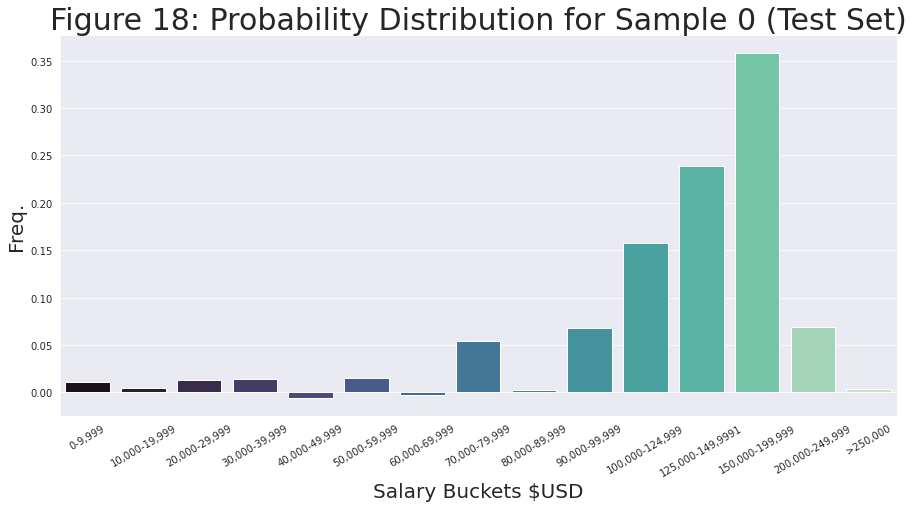

In [ ]:
plt.figure(figsize=(15,7))
fig = sns.barplot(y= test_dists[0][0], x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], palette='mako') #distribution of sample point 0
plt.title('Figure 18: Probability Distribution for Sample 0 (Test Set)', fontsize = 30)
fig.set_xticklabels(salary_order, rotation = 30)
print('Actual true salary bucket is:,', kaggle.loc[0,:][-1])
fig.set_xlabel('Salary Buckets $USD', fontsize = 20)
fig.set_ylabel('Freq.', fontsize = 20);

Actual true salary bucket is:, 10,000-19,999


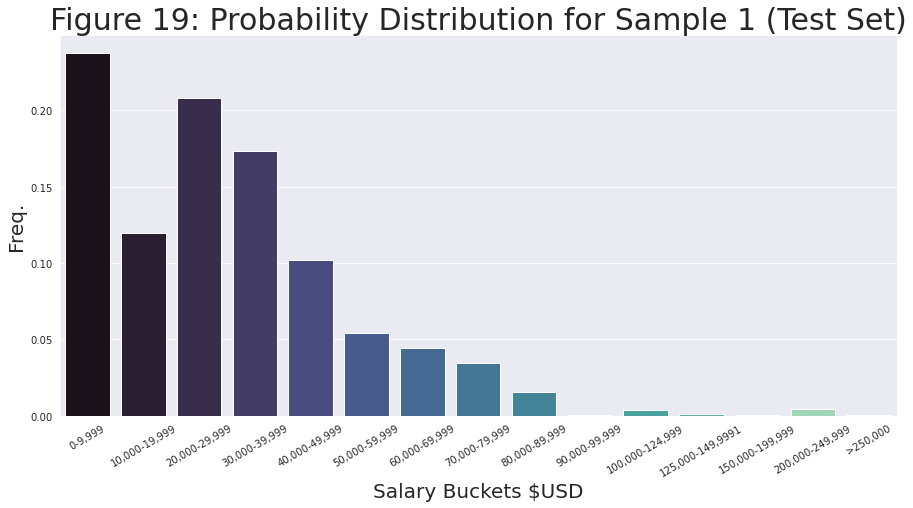

In [ ]:
plt.figure(figsize=(15,7))
fig = sns.barplot(y= test_dists[0][1], x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], palette='mako') #distribution of sample point 1
plt.title('Figure 19: Probability Distribution for Sample 1 (Test Set)', fontsize = 30)
fig.set_xticklabels(salary_order, rotation = 30)
print('Actual true salary bucket is:,', kaggle.loc[1,:][-1])
fig.set_xlabel('Salary Buckets $USD', fontsize = 20)
fig.set_ylabel('Freq.', fontsize = 20);

Actual true salary bucket is:, 125,000-149,9991


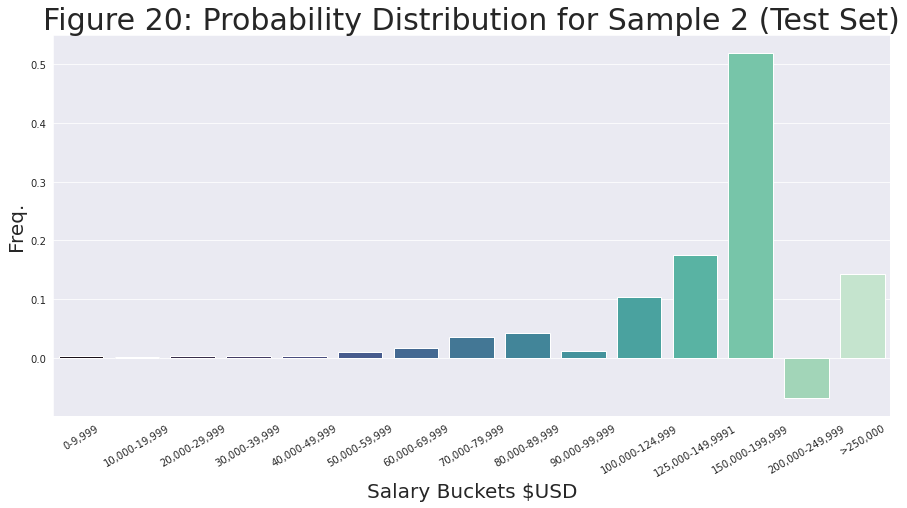

In [ ]:
plt.figure(figsize=(15,7))
fig = sns.barplot(y= test_dists[0][2], x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], palette='mako') #distribution of sample point 2
plt.title('Figure 20: Probability Distribution for Sample 2 (Test Set)', fontsize = 30)
fig.set_xticklabels(salary_order, rotation = 30)
print('Actual true salary bucket is:,', kaggle.loc[2,:][-1])
fig.set_xlabel('Salary Buckets $USD', fontsize = 20)
fig.set_ylabel('Freq.', fontsize = 20);

Next we will plot the overall distributions of the training and test sets along with their predicted values from the model (90% training and 10% test corresponding to the first fold of our 10-fold CV). First well redefine the split indexes of the different folds. 

In [ ]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Next well display the distributions of true value of the training data and its predicted class ouputted from the model for the first fold. 

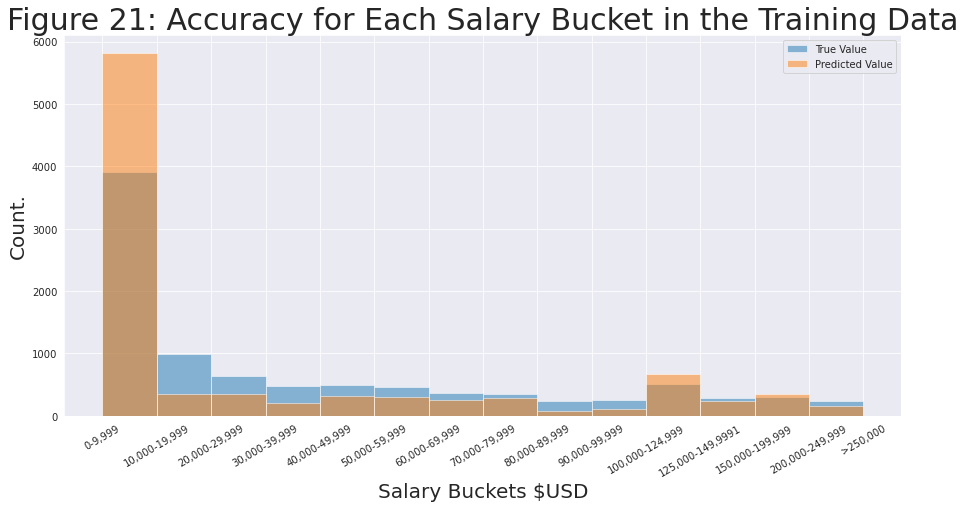

In [ ]:
plt.figure(figsize=(15,7))
y_train_pred = np.argmax(training_dists[0],axis = 1)
plt.hist(y.iloc[train_index], range(15), alpha=0.5, label='True Value')
plt.hist(y_train_pred, range(15), alpha=0.5, label='Predicted Value')

plt.title('Figure 21: Accuracy for Each Salary Bucket in the Training Data', fontsize = 30)
plt.xticks(range(15),labels = salary_order, rotation = 30);
plt.xlabel('Salary Buckets $USD', fontsize = 20)
plt.ylabel('Count.', fontsize = 20);
plt.legend();



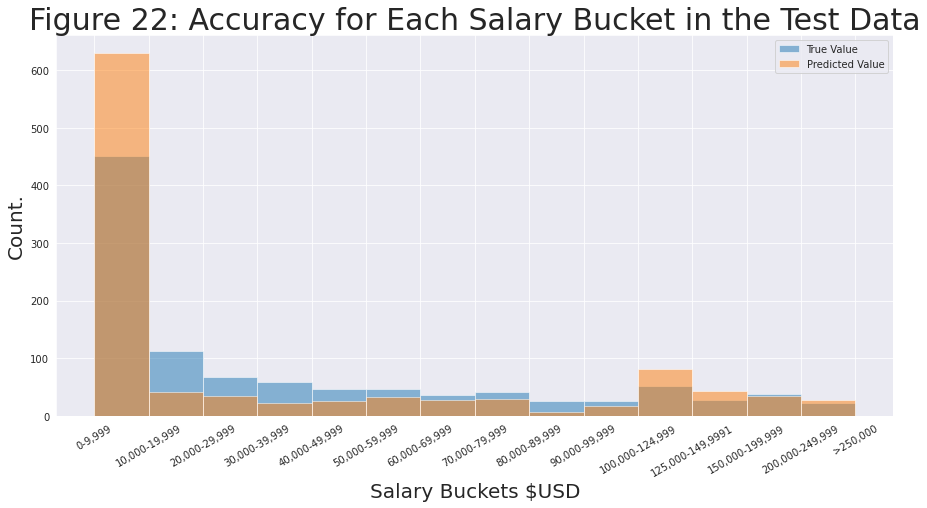

In [ ]:
plt.figure(figsize=(15,7))
y_test_pred = np.argmax(test_dists[0],axis = 1)
plt.hist(y.iloc[test_index], range(15), alpha=0.5, label='True Value')
plt.hist(y_test_pred, range(15), alpha=0.5, label='Predicted Value')

plt.title('Figure 22: Accuracy for Each Salary Bucket in the Test Data', fontsize = 30)
plt.xticks(range(15),labels = salary_order, rotation = 30);
plt.xlabel('Salary Buckets $USD', fontsize = 20)
plt.ylabel('Count.', fontsize = 20);
plt.legend();

As we can see in the Figures above the training and test distributions are  similar for the true values which makes sense given they are a sample from the total dataset. We also observe the predicted distribution for the trainin and test points are very similar which makes sense given that the training distributions are also similar. 

Within the training and test data it appears the predicted distribution has many more predictions of the lowest salary bucket almost makes no prediction of the salary buckets in between. The second most predicted salary bucket is 100,000-124,999. This could be partially due to the fact that the majority of our training data is from these two classes and so our data is very skewed.  The low accuracy of our model can be explained by those bars from the true values which have very little overlap with the bars from the predicted values. 

In this case it is the salary buckets that are not 0-9,999 or 10000-124,999 which appear to have the lowest accuracy and hence result in our model performing poorly. 

In fact we can calcualte the accuracy of each class to investigate this idea further. 

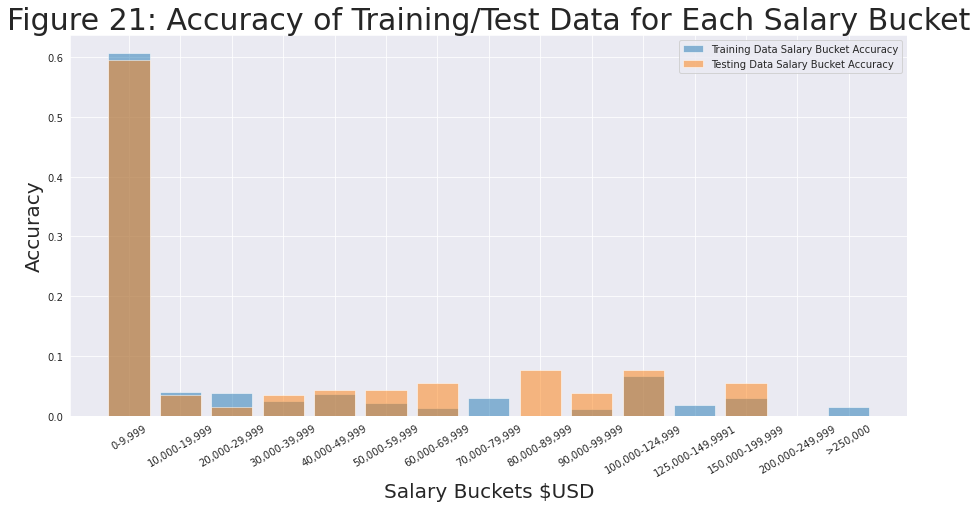

In [ ]:
train_class_accuracy = []
test_class_accuracy = []

a = pd.DataFrame(y_train_pred)
b = pd.DataFrame(y_test_pred)
a_true = pd.DataFrame(y.loc[train_index])
b_true = pd.DataFrame(y.loc[test_index])

for i in range(15):
    a_class_index = a_true[a_true==i].dropna().index
    b_class_index = b_true[b_true==i].dropna().index
    train_acc = accuracy_score(a_true.loc[a_class_index], a.loc[a_class_index])
    test_acc = accuracy_score (b_true.loc[b_class_index], b.loc[b_class_index-9477])
    train_class_accuracy.append(train_acc)
    test_class_accuracy.append(test_acc)

plt.figure(figsize=(15,7))
plt.bar(x = range(15), height = train_class_accuracy, alpha=0.5, label='Training Data Salary Bucket Accuracy')
plt.bar(x = range(15), height = test_class_accuracy, alpha=0.5, label='Testing Data Salary Bucket Accuracy')

plt.title('Figure 21: Accuracy of Training/Test Data for Each Salary Bucket', fontsize = 30)
plt.xticks(range(15),labels = salary_order, rotation = 30);
plt.xlabel('Salary Buckets $USD', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20);
plt.legend();

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jupyterlab/conda/envs/pyth

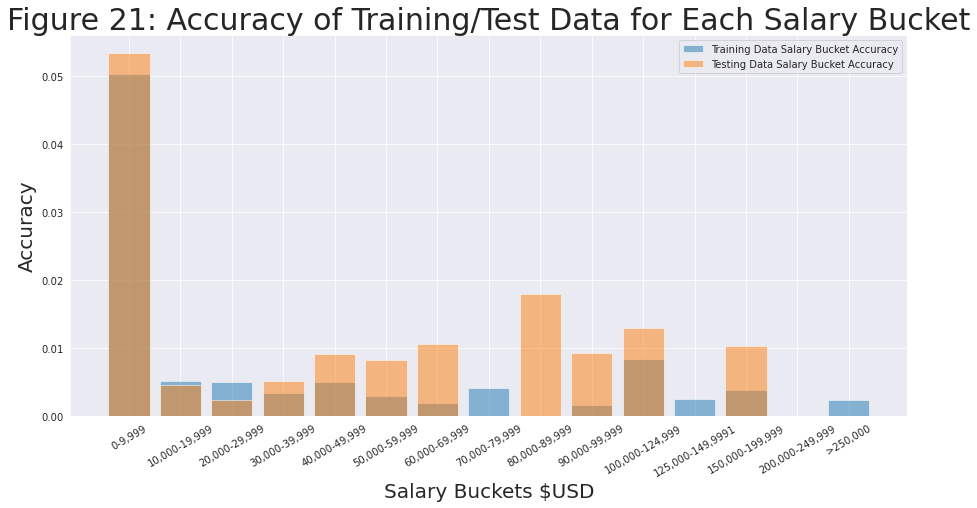

In [ ]:
train_class_f1 = []
test_class_f1 = []

a = pd.DataFrame(y_train_pred)
b = pd.DataFrame(y_test_pred)
a_true = pd.DataFrame(y.loc[train_index])
b_true = pd.DataFrame(y.loc[test_index])

for i in range(15):
    a_class_index = a_true[a_true==i].dropna().index
    b_class_index = b_true[b_true==i].dropna().index
    train_acc = f1_score(a_true.loc[a_class_index], a.loc[a_class_index], average = 'macro')
    test_acc = f1_score (b_true.loc[b_class_index], b.loc[b_class_index-9477], average = 'macro')
    train_class_f1.append(train_acc)
    test_class_f1.append(test_acc)

plt.figure(figsize=(15,7))
plt.bar(x = range(15), height = train_class_f1, alpha=0.5, label='Training Data Salary Bucket Accuracy')
plt.bar(x = range(15), height = test_class_f1, alpha=0.5, label='Testing Data Salary Bucket Accuracy')

plt.title('Figure 21: Accuracy of Training/Test Data for Each Salary Bucket', fontsize = 30)
plt.xticks(range(15),labels = salary_order, rotation = 30);
plt.xlabel('Salary Buckets $USD', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20);
plt.legend();

As shown in the figure above the accuracy for predicting the 0 - 9,999 bucket is very high at roughly 75%. This could simply be because our data is so skewed and we have many training examples for this class. Therefore the model can better predict samples that are this salary bucket. Additionally there are many more samples of this class so we are more likely to guess correctly just based on the fact that there is a higher frequency of this salary bucket in the dataset.

##Summary

- Cleaned the data by imputing missing values with appropriate values. Removed samples corresponding to missing vlaues when appropriate. Removed unncessary columns such as time duration of survey. Removed survey samples that were completed in under 3 minutes.

- Explored various features such as Age, Gender and Education and plotted their distributions for different salary buckets. Aggregated Education and Country features to reduce dimensionality before encoding. Removed non Woman or Man gender selection samples. 

- Observed that the data is highly skewed and most survey respondents belong to the lowest salary bucket. This could be important when analyzing the results of the logistic regression model. 

- Used One-hot encoding for all data given they are categorical without order or the order is not uniform. 

- Computed correlation of dataset and visualized results using a heatmap. Used PCA to select 220 components which explained 90% of the variance in our dataset.

- Trained the model without CV, with CV. Accuracy approximately 0.44 and F1 score of 0.33. Relatively poor results.

- Hyperparameter tuning of regularization penalty (L1, L2) and inverse regularization strength C (0.1, 1, 10, 100). Hyperparameters corresponding to best model is L2 and C = 100 but the accuracy and F1 score barely changed. This further confirms the model is very underfitted. 

- Plotted the distribution of probabilities for training and test points belonging to each salary bucket. The probabilities appear to overestimate the first salary class and very rarely predict those from other salary classes. Visualized the accuraccy of guessing each class and found an approximate accuracy of 75% in estimating the first class while very low accuracy for the remaining. This further suggests our model has not learned well due to the skewedness of the data and is underfitted. We need to add complexity to the model by including more features perhaps polynomial features to capture nonlinear relations.